In [5]:
# Uncomment the below line when the entry point cannot be found (why am I getting this error??)
#import cmdstanpy; cmdstanpy.install_cmdstan(compiler = True, overwrite = True)

Installing CmdStan version: 2.32.2
Install directory: C:\Users\manny\.cmdstan
Download successful, file: C:\Users\manny\AppData\Local\Temp\tmpx78ggcqz
Extracting distribution
Unpacked download as cmdstan-2.32.2
Building version cmdstan-2.32.2, may take several minutes, depending on your system.
Overwrite requested, remove existing build of version cmdstan-2.32.2
Rebuilding version cmdstan-2.32.2
Test model compilation
Installed cmdstan-2.32.2


True

In [34]:
# Importing necessary dependencies
DRAFT = True
import itertools
import logging
import warnings
import numpy as np
print(np.version.version)
#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.filterwarnings("ignore", "plotnine\..*")

import cmdstanpy as csp
csp.utils.get_logger().setLevel(logging.ERROR)


import statistics as stat
import pandas as pd
import plotnine as pn
import patchworklib as pw


# This works with printing instead of drawing: https://lightrun.com/answers/spyder-ide-spyder-plotnine-plots-not-showing-up
def mydraw(x):
    """draw plot in the quarto doc"""
    #x.draw()
    print(x)

1.23.1


In [35]:
f = open('binomial-rng.stan', 'w')
f.write("""

data {
    int<lower=0> N;
    real<lower=0, upper=1> theta;
}
generated quantities{
    int<lower=0, upper=N> y = binomial_rng(N, theta);
}

""")
f.close()

In [36]:
# Drawing 10 samples from the first model
N = 100
theta = 0.3
data = {'N': N, 'theta': theta}
model = csp.CmdStanModel(stan_file = 'binomial-rng.stan')
sample = model.sample(data = data, seed = 123, chains = 1, 
                      iter_sampling = 10, iter_warmup = 0, 
                      show_progress = True, show_console = True)

Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 10
Chain [1] num_warmup = 0
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = C:\Users\manny\AppData\Local\Temp\tmp4eq_wbde\7l6c1kqq.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 123
Chain [1] output
Ch

In [37]:
# Number of clinical trial successes with 10 samples consisting of 100 patients and a 30% probability of success
y = sample.stan_variable('y')
print("N = ", N, "; theta = ", theta, "; y(0:10) = ", *y.astype(int))

N =  100 ; theta =  0.3 ; y(0:10) =  33 36 30 28 37 26 25 19 29 33


In [38]:
# Running a looped version of the above scenario
for N in [10, 100, 1_000, 10_000]:
    data = {'N': N, 'theta': theta}
    sample = model.sample(data = data, seed = 123, chains = 1,
                          iter_sampling = 10, iter_warmup = 0,
                          show_progress = False,
              show_console = False)
    y = sample.stan_variable('y')
    print("N =", N)
    print("  y: ", *y.astype(int))
    print("  est. theta: ", *(y / N))

N = 10
  y:  4 4 3 4 3 3 3 5 2 4
  est. theta:  0.4 0.4 0.3 0.4 0.3 0.3 0.3 0.5 0.2 0.4
N = 100
  y:  33 36 30 28 37 26 25 19 29 33
  est. theta:  0.33 0.36 0.3 0.28 0.37 0.26 0.25 0.19 0.29 0.33
N = 1000
  y:  322 324 306 333 311 318 294 323 282 311
  est. theta:  0.322 0.324 0.306 0.333 0.311 0.318 0.294 0.323 0.282 0.311
N = 10000
  y:  3049 3052 3012 3025 3042 3087 3051 2922 2943 3025
  est. theta:  0.3049 0.3052 0.3012 0.3025 0.3042 0.3087 0.3051 0.2922 0.2943 0.3025


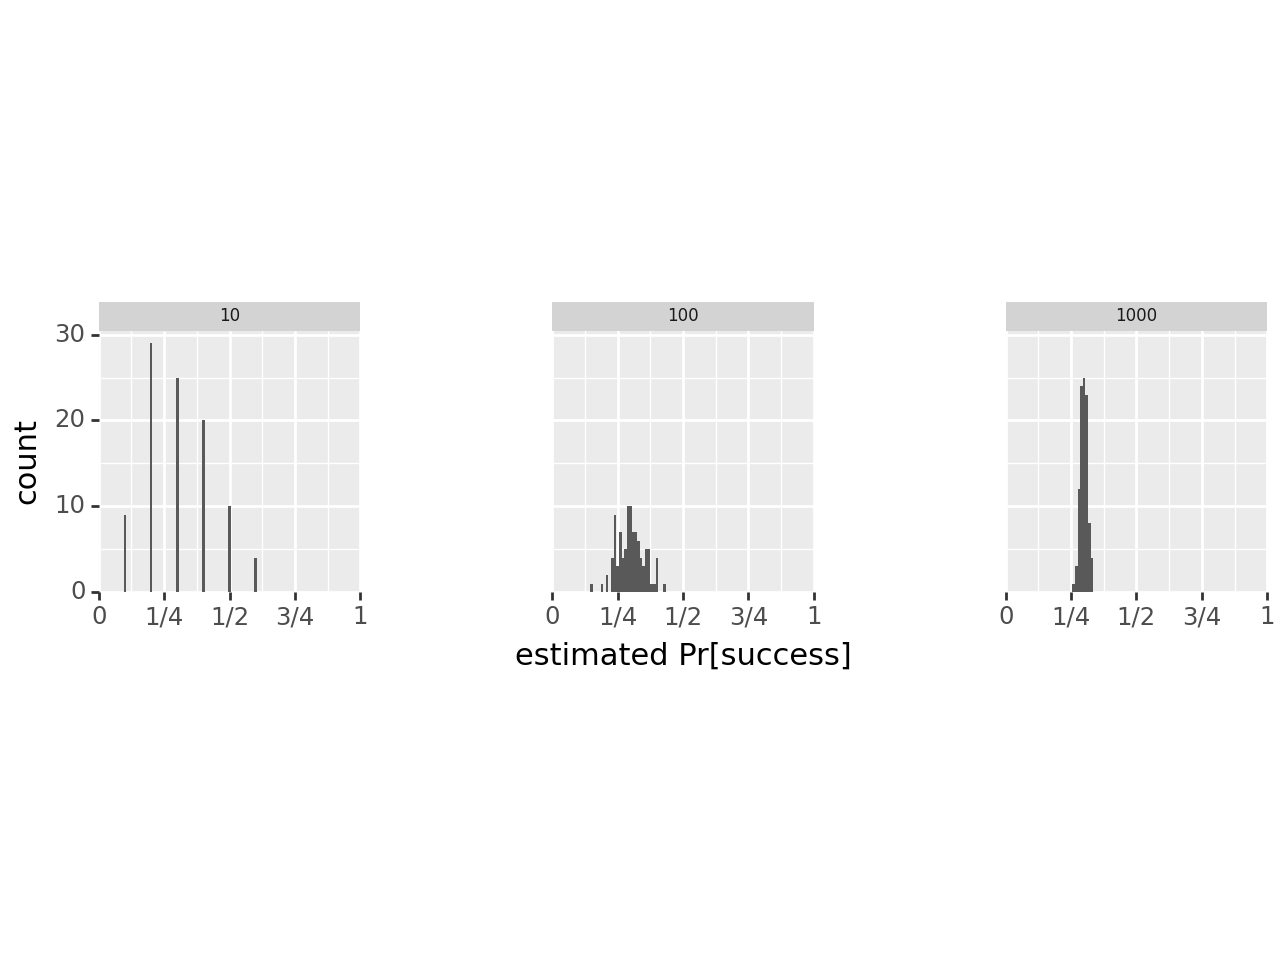

In [39]:
# Plotting for different sizes of N, and for 100,000 values of y

np.random.seed(123)
ts = []
ps = []
theta = 0.3
M = 100 if DRAFT else 100000
for N in [10, 100, 1000]:
    data = {'N': N, 'theta': theta}
    sample = model.sample(data = data, seed = 123, chains = 1, iter_sampling = M, iter_warmup = 0, 
                          show_progress = False, show_console = False)
    y = sample.stan_variable('y')
    theta_hat = y/N
    ps.extend(theta_hat)
    ts.extend(itertools.repeat(N, M))
xlabel = 'estimated Pr[success]'
df = pd.DataFrame({xlabel: ps, 'trials': ts})

# I used print here instead of draw? Interesting
mydraw(pn.ggplot(df, pn.aes(x = xlabel))
       + pn.geom_histogram(binwidth = 0.01)
       + pn.facet_grid('. ~ trials')
       + pn.scales.scale_x_continuous(limits = [0,1], breaks = [0, 1/4, 1/2, 3/4, 1],
                                     labels = ["0", "1/4", "1/2", "3/4", "1"], expand = [0, 0])
       + pn.scales.scale_y_continuous(expand = [0, 0, 0.05, 0])
       + pn.theme(aspect_ratio = 1, panel_spacing = 0.15,
                 strip_text = pn.element_text(size = 6),
                 strip_background = pn.element_rect(height = 0.08,
                                                   fill = "lightgray")))

In [40]:
# Stan generates based on a random seed

for seed in [123, 19876, 123]:
    sample = model.sample(data = data, seed = seed, chains = 1,
                         iter_sampling = 10, iter_warmup = 0,
                         show_progress = False, show_console = False)
    print(f"{seed = }; sample = {np.asarray(sample.stan_variable('y'), dtype = 'int')}")

seed = 123; sample = [322 324 306 333 311 318 294 323 282 311]
seed = 19876; sample = [286 303 286 309 289 276 317 298 328 294]
seed = 123; sample = [322 324 306 333 311 318 294 323 282 311]


In [41]:
# Creating a Stan document for monte carlo pi estimation

f = open('monte-carlo-pi.stan', 'w')
f.write("""

generated quantities{
    real<lower = -1, upper = 1> x = uniform_rng(-1, 1);
    real<lower = -1, upper = 1> y = uniform_rng(-1, 1);
    int<lower = 0, upper = 1> inside = x^2 + y^2 < 1;
    real<lower = 0, upper = 4> pi = 4*inside;
}

""")
f.close()

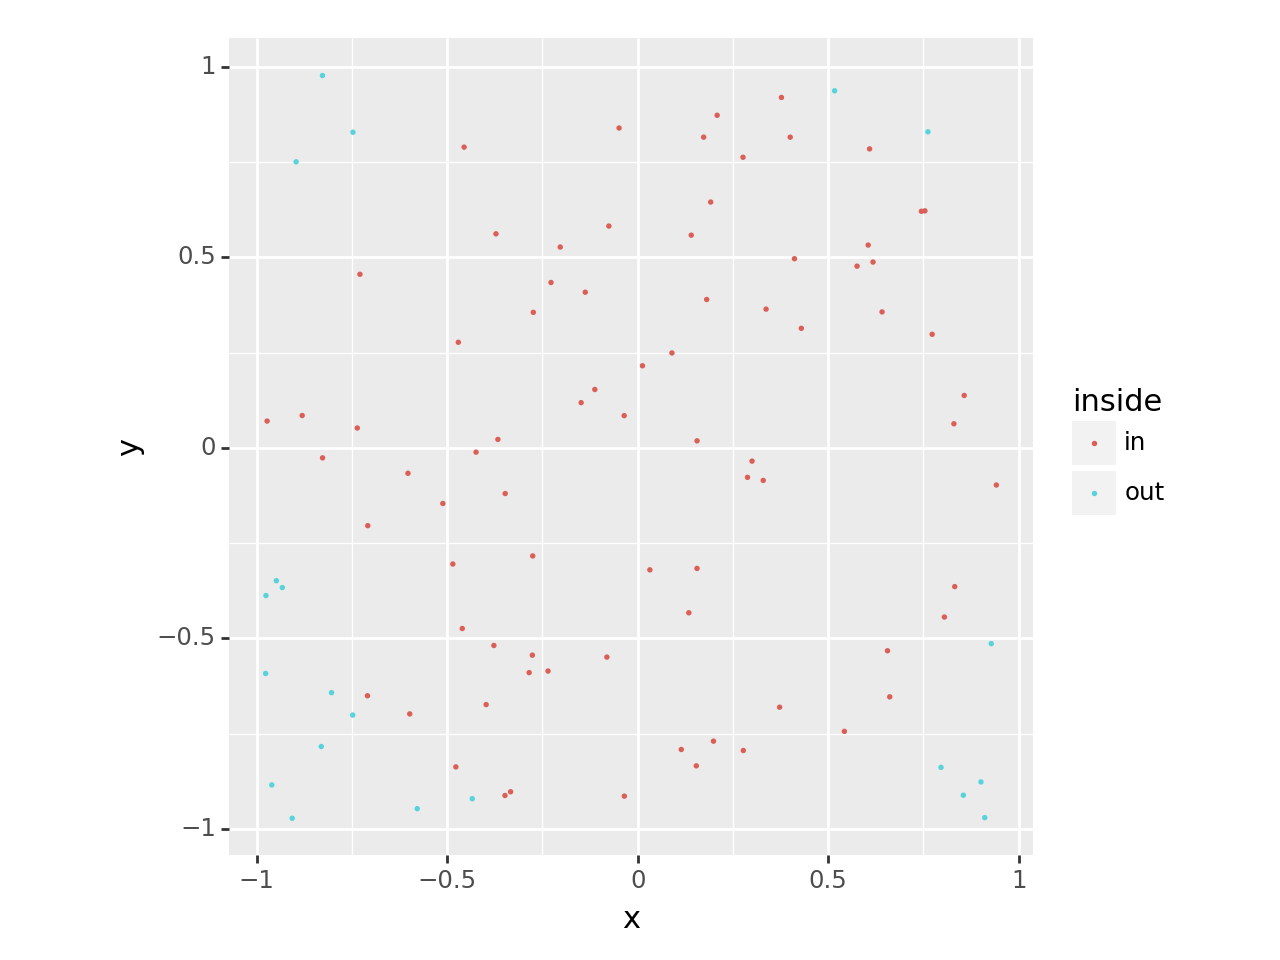

In [42]:
# Estiamting the area of pi with monte carlo 

M = 100 if DRAFT else 10_000
model = csp.CmdStanModel(stan_file = 'monte-carlo-pi.stan')
sample = model.sample(chains = 1, iter_warmup = 0, iter_sampling = M,
                      show_progress = False, show_console = False,
                      seed = 123)
x_draws = sample.stan_variable('x')
y_draws = sample.stan_variable('y')
inside_draws = [int(i) for i in sample.stan_variable('inside')]
pi_draws = sample.stan_variable('pi')
inside_named_draws = np.array(["out", "in"])[inside_draws]
df = pd.DataFrame({'x': x_draws, 'y': y_draws,
                   'inside': inside_named_draws})
mydraw(
  pn.ggplot(df, pn.aes(x = 'x', y = 'y',
                group='inside', color='inside'))
  + pn.geom_point(size = 0.1)
  + pn.labs(x = 'x', y = 'y')
  + pn.coord_fixed(ratio = 1)
)

In [43]:
# Esimate of pi 
P_inside = np.mean(inside_draws)
pi_hat = np.mean(pi_draws)
print(f"Pr[Y is inside circle] = {P_inside:.3f};")
print(f"estimate for pi = {pi_hat:.3f}")

Pr[Y is inside circle] = 0.790;
estimate for pi = 3.160


In [44]:
# Stan file for first MCMC

f = open('markov-autocorrelation.stan', 'w')
f.write("""

data {
    int<lower = 0> M;
    real<lower = 0, upper = 1> rho;
}

generated quantities{
    array[M] int<lower = 0, upper = 1> y;
    y[1] = bernoulli_rng(0.5);
    for (m in 2:M){
        y[m] = bernoulli_rng(y[m-1] ? rho: 1-rho);
    }
}

""")
f.close()

In [45]:
# Markov chain sumulated accorded to above

model = csp.CmdStanModel(stan_file = 'markov-autocorrelation.stan')
M = 100 if DRAFT else 1000
rhos = []
iterations = []
draws = []
estimates = []
for rho in [0.05, 0.5, 0.95]:
    data = {'M': M, 'rho': rho}
    sample = model.sample(data = data, seed = 123, chains = 1,
                      iter_warmup = 0, iter_sampling = 1,
                      show_progress = False, show_console = False)
    y_sim = sample.stan_variable('y')
    cum_sum = np.cumsum(y_sim)
    its = np.arange(1, M + 1)
    ests = cum_sum / its
    draws.extend(y_sim[0])
    iterations.extend(its)
    estimates.extend(ests)
    rhos.extend(itertools.repeat(str(rho), M))
df = pd.DataFrame({'draw': draws, 'iteration': iterations,
                   'estimate': estimates, 'rho': rhos})
rho05 = np.array(df.query('rho == "0.05"').head(100)['draw'], dtype = 'int')
rho50 = np.array(df.query('rho == "0.5"').head(100)['draw'], dtype = 'int')
rho95 = np.array(df.query('rho == "0.95"').head(100)['draw'], dtype = 'int')
print("Markov chain draw with probability rho of repeating last value:\n")
print("rho = 0.05:", rho05, "\n")
print("rho = 0.50:", rho50, "\n")
print("rho = 0.95:", rho95, "\n")

Markov chain draw with probability rho of repeating last value:

rho = 0.05: [0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1] 

rho = 0.50: [0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0
 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0 0
 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0] 

rho = 0.95: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0] 



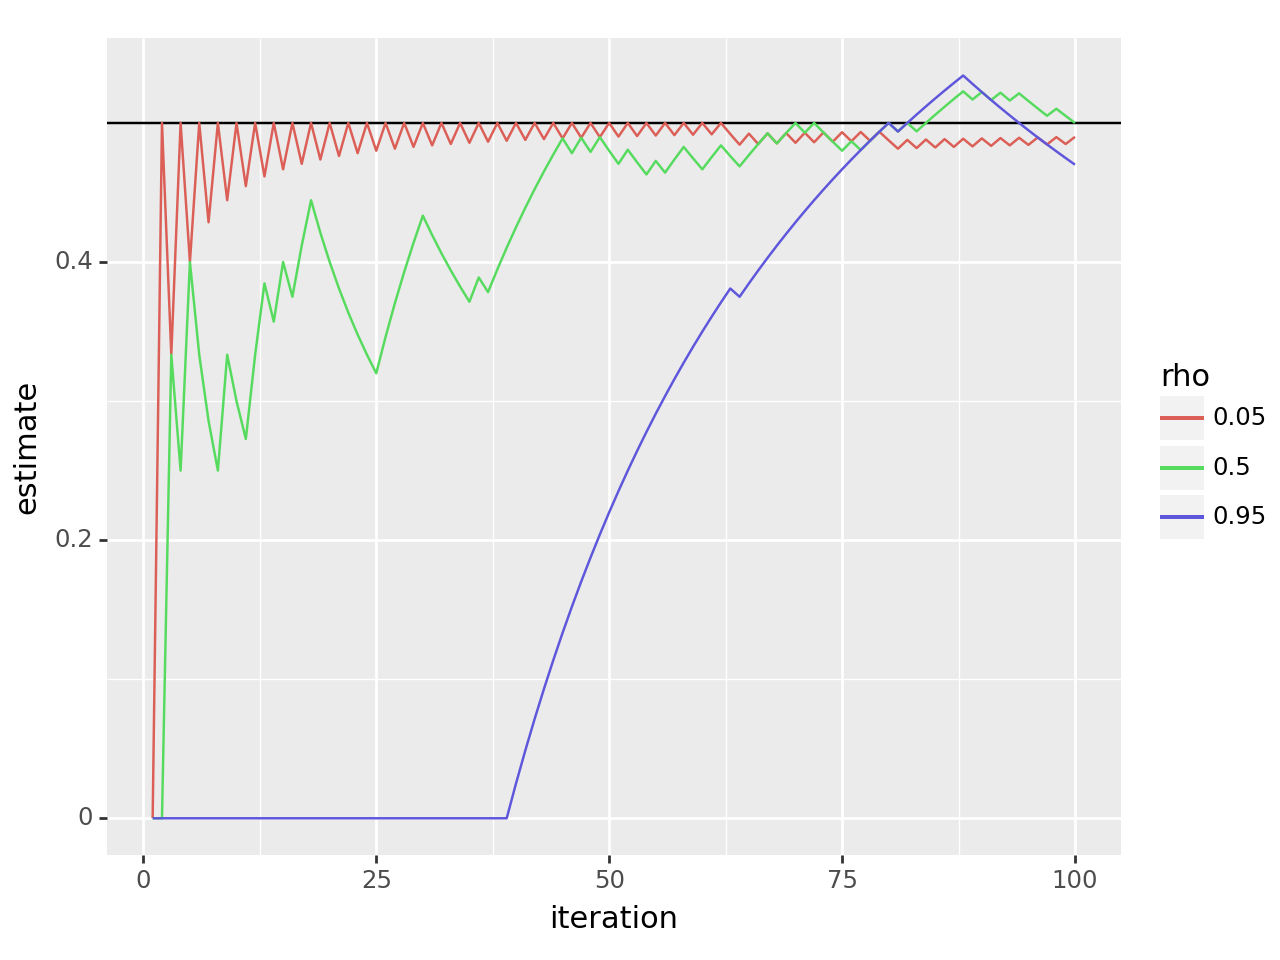

In [46]:
mydraw(
    pn.ggplot(df, pn.aes(x='iteration', y='estimate',
                  group='rho', color='rho'))
    + pn.geom_hline(yintercept = 0.5, color = 'black')        
    + pn.geom_line()
    + pn.labs(x = "iteration", y = "estimate")
)

In [47]:
# It is more efficent to iterate by column than by row in Stan
# Stan is 1-indexed
# Stan loops are inclusive

In [48]:
# Laplace Birth Data

f = open('sex-ratio.stan', 'w')
f.write("""

data {
    int<lower = 0> N;
    int<lower = 0, upper = N> y;
}

parameters{
    real<lower=0, upper=1> theta;
}

model{
    theta ~ beta(1, 1);
    y ~ binomial(N, theta);
}

generated quantities{
    int<lower=0, upper = 1> boys_gt_girls = theta > 0.5;
}

""")
f.close()

In [49]:
model = csp.CmdStanModel(stan_file = "sex-ratio.stan")
boys = 110312
girls = 105287
data = {'N': boys + girls, 'y': boys}
M = 100 if DRAFT else 10000
sample = model.sample(data = data, seed =123, 
                      iter_sampling = M, iter_warmup = 1000,
                      show_progress = False, show_console = False)

theta_draws = sample.stan_variable('theta')
boys_gt_girls_draws = sample.stan_variable('boys_gt_girls')

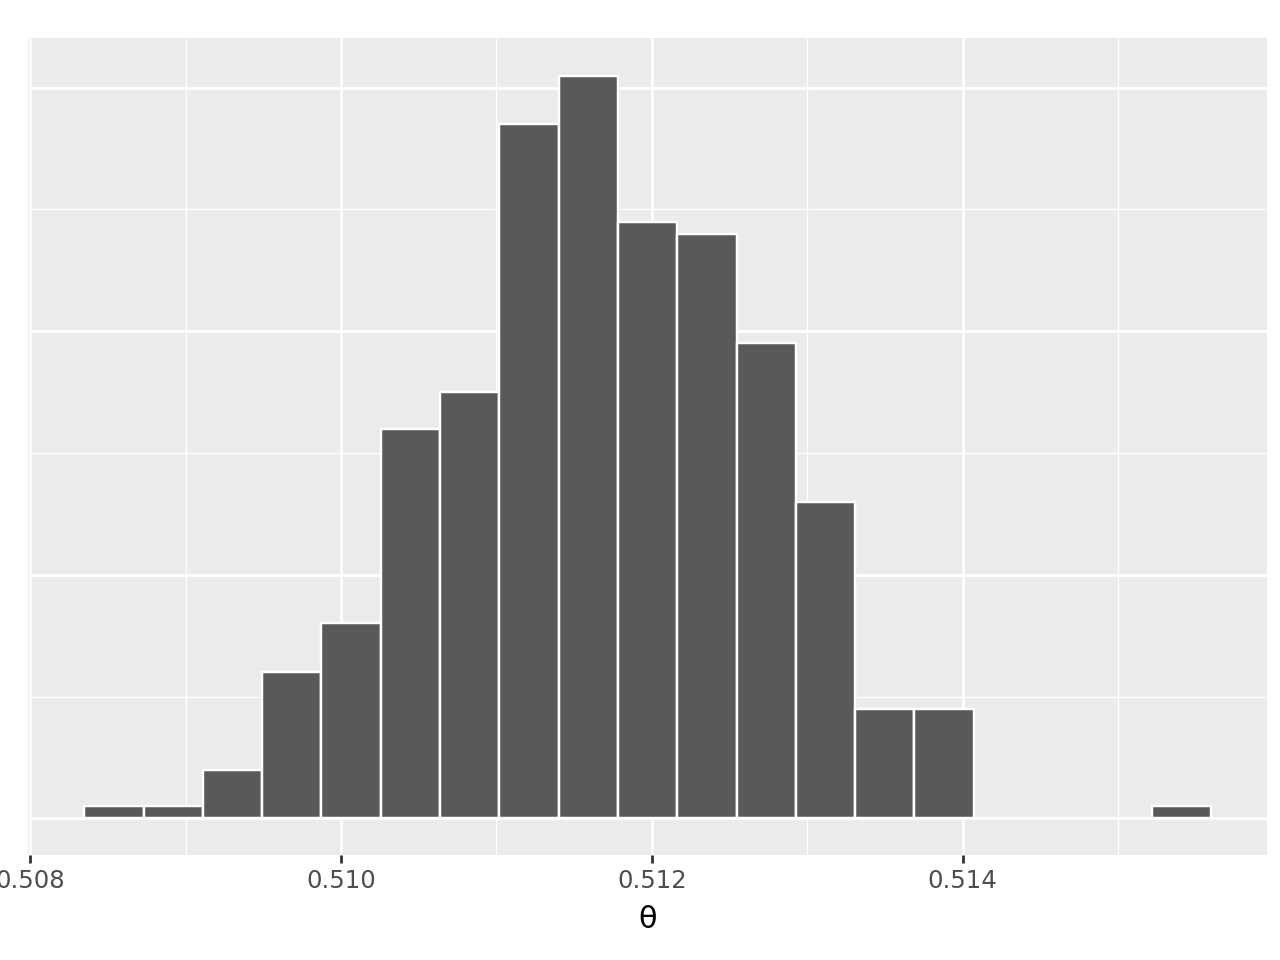

In [50]:
mydraw(
  pn.ggplot(pd.DataFrame({'theta': theta_draws}),
            pn.aes(x = 'theta')) +
  pn.geom_histogram(color='white') +
  pn.labs(x = 'θ') +
  pn.theme(axis_text_y = pn.element_blank(),
           axis_title_y = pn.element_blank(),  
           axis_ticks_major_y = pn.element_blank())
)

In [51]:
# Point estiamte of male birth rate
theta_hat = np.mean(theta_draws)
print(f"estimated theta = {theta_hat:.3f}")

# Posterior median estimate
theta_plus = np.median(theta_draws)
print(f"estimated (median) theta = {theta_plus:.3f}")

# Quantiles for birth rate
quantile_05 = np.quantile(theta_draws, 0.025)
quantile_95 = np.quantile(theta_draws, 0.975)
print(f"""0.05 quantile = {quantile_05:.3f};
0.95 quantile = {quantile_95:.3f}""")

# 90 posterior interval
print(f"central 90% posterior interval for theta")
print(f"    = ({quantile_05:.3f}, {quantile_95:.3f})")

# Solution
Pr_boy_gt_girl = np.mean(boys_gt_girls_draws)
print(f"estimated Pr[boy more likely] = {Pr_boy_gt_girl:.15f}")

# Machine Precision in Python
print(f"{(1.0 == (1.0 - 1e-27)) = }")
print(f"Machine precision: {np.finfo(float).eps}")

estimated theta = 0.512
estimated (median) theta = 0.512
0.05 quantile = 0.510;
0.95 quantile = 0.514
central 90% posterior interval for theta
    = (0.510, 0.514)
estimated Pr[boy more likely] = 1.000000000000000
(1.0 == (1.0 - 1e-27)) = True
Machine precision: 2.220446049250313e-16


In [52]:
# MCMC Summary in Stan

sample.summary(sig_figs = 3)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-149000.000,0.036200,6.030000e-01,-149000.00,-149000.000,-149000.000,277.0,12600.0,1.00
theta,0.512,0.000074,1.030000e-03,0.51,0.512,0.513,196.0,8890.0,1.01
boys_gt_girls,1.000,NaN,6.670000e-16,1.00,1.000,1.000,NaN,NaN,NaN


In [53]:
# A/B Testing for Restaurant Quality

f = open('ab-test.stan', 'w')
f.write("""

data {
  int<lower=0> K;
  array[K] int<lower=0> trials;
  array[K] int<lower=0> successes;
  real<lower=0> alpha;  
  real<lower=0> beta;  
}
parameters {
  array[K] real<lower=0, upper=1> theta;
}
model {
  successes ~ binomial(trials, theta);
  theta ~ beta(alpha, beta);
}
generated quantities {
  array[K] int<lower=0, upper=1> is_best;
  for (k in 1:K) {
    is_best[k] = theta[k] == max(theta);
  }
}

""")
f.close()

In [56]:
M = 100 if DRAFT else 1000
model = csp.CmdStanModel(stan_file = 'ab-test.stan')
data = {'K': 3, 'trials': [276, 143, 87],
        'successes': [141, 84, 41],
        'alpha': 2, 'beta': 2}
sample = model.sample(data = data, seed = 123,
                     iter_warmup = M, iter_sampling = M,
                     show_progress = False, show_console = False)
sample.summary(sig_figs = 2)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-360.000,0.0880,1.200,-360.00,-360.00,-360.00,180.0,4200.0,1.00
theta[1],0.510,0.0013,0.031,0.46,0.51,0.56,543.0,12628.0,0.99
theta[2],0.590,0.0021,0.040,0.53,0.59,0.66,377.0,8767.0,1.00
theta[3],0.470,0.0027,0.046,0.39,0.47,0.55,285.0,6625.0,0.99
is_best[1],0.048,0.0120,0.210,0.00,0.00,0.00,302.0,7024.0,1.00
is_best[2],0.940,0.0140,0.250,0.00,1.00,1.00,315.0,7332.0,1.00
is_best[3],0.018,NaN,0.130,0.00,0.00,0.00,NaN,NaN,NaN


In [62]:
type(df)

sklearn.utils.Bunch

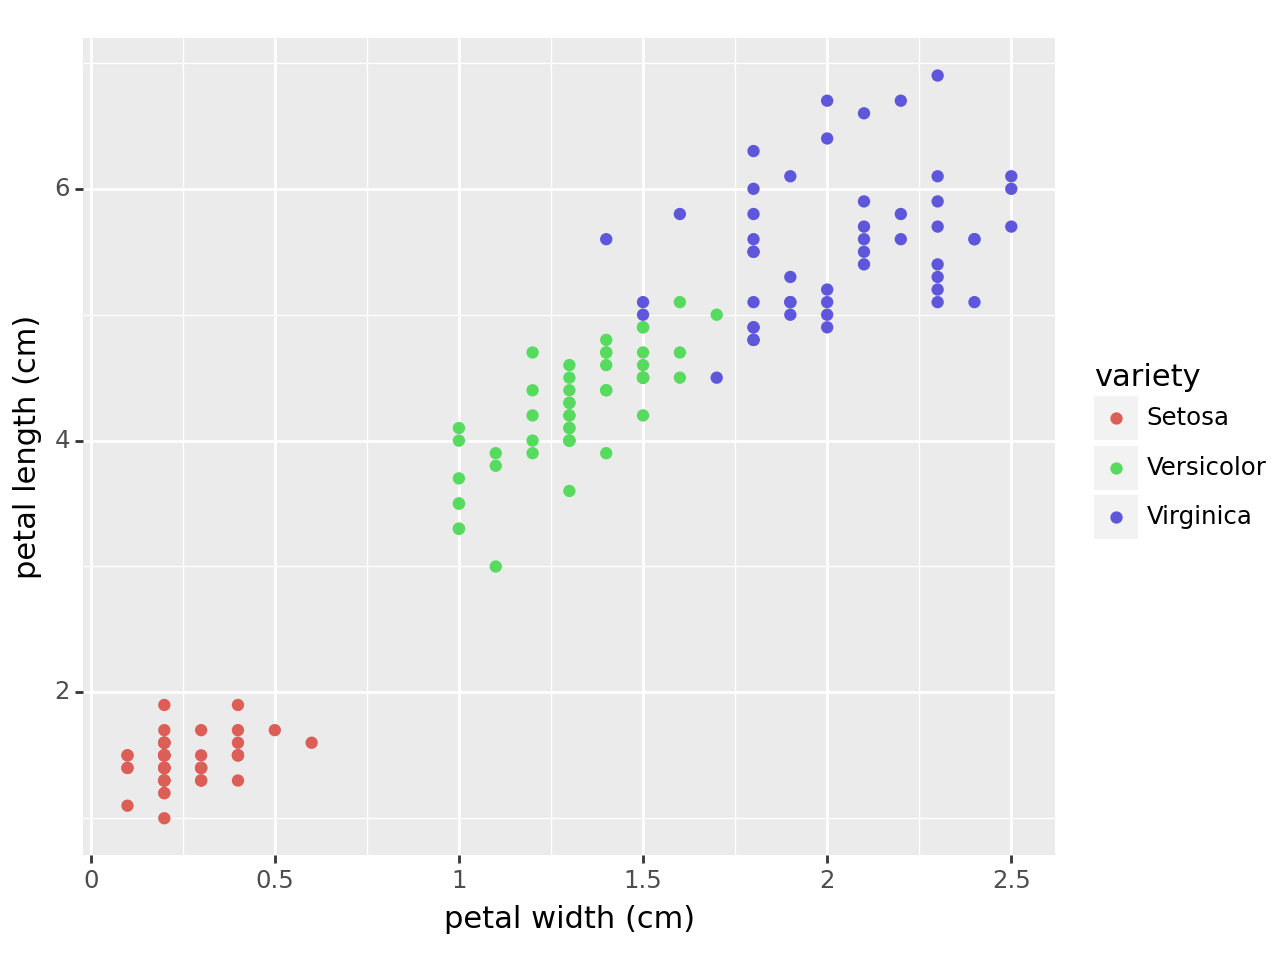

In [69]:
import sklearn.datasets as ds
df = pd.read_csv('iris.csv')

mydraw(
  pn.ggplot(df, pn.aes(x='petal.width', y='petal.length',
                       color='variety')) +
  pn.geom_point() +
  pn.labs(x = "petal width (cm)", y = "petal length (cm)")
)

In [67]:
df.columns

Index(['sepal.length', 'sepal.width', 'petal.length', 'petal.width',
       'variety'],
      dtype='object')

In [70]:
f = open('iris-petals.stan', 'w')
f.write("""

data {
  int<lower=0> N;
  vector<lower=0>[N] petal_width;
  vector<lower=0>[N] petal_length;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  petal_length ~ normal(alpha + beta * petal_width, sigma);
  alpha ~ normal(0, 5);
  beta ~ normal(0, 5);
  sigma ~ lognormal(0, 1);
}


""")
f.close()

In [74]:
def iris_data_frame():
    return pd.read_csv('iris.csv')

def iris_data():
    df = iris_data_frame()
    N = df.shape[0]
    petal_width = df['petal.width']
    petal_length = df['petal.length']
    species = 1 + pd.Series(df['variety']).astype('category').cat.codes
    num_species = 3
    data = {'N': N,
            'K': num_species,
            'species': species,
            'petal_width': petal_width,
            'petal_length': petal_length,}
    return data

M = 100 if DRAFT else 1000
model = csp.CmdStanModel(stan_file = 'iris-petals.stan')
sample = model.sample(data = iris_data(), seed = 123,
                      iter_warmup = M, iter_sampling = M,       
                      show_progress = False, show_console = False)
sample.summary(sig_figs = 2)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,34.00,0.0700,1.000,32.00,34.00,35.00,220.0,3400.0,0.99
alpha,1.10,0.0054,0.069,0.97,1.10,1.20,160.0,2500.0,1.00
beta,2.20,0.0039,0.051,2.10,2.20,2.30,170.0,2700.0,1.00
sigma,0.48,0.0015,0.026,0.44,0.48,0.53,320.0,5100.0,1.00


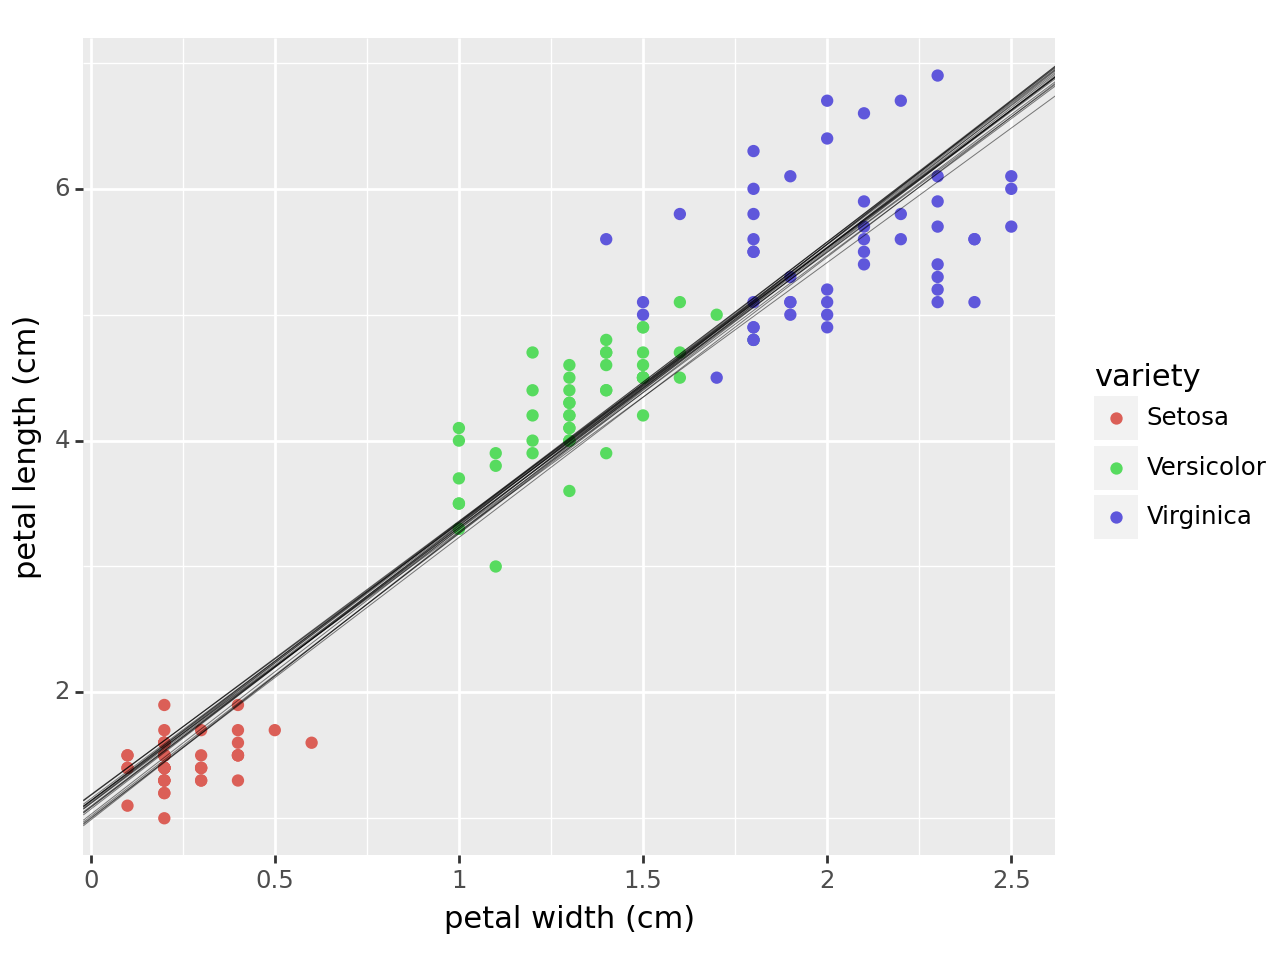

In [76]:
alpha_draws = sample.stan_variable('alpha')
beta_draws = sample.stan_variable('beta')
plot =  pn.ggplot(df, pn.aes(x='petal.width', y='petal.length',
                             color='variety'))
plot = plot +  pn.geom_point()
plot = plot +  pn.labs(x = "petal width (cm)", y = "petal length (cm)")
for a, b in zip(alpha_draws[0:20], beta_draws[0:20]):
    plot = plot + pn.geom_abline(intercept = a, slope = b,
                                 alpha = 0.5, size = 0.2)
mydraw(
  plot
)

In [77]:
# Posterior Prediction

f = open('iris-predict.stan', 'w')
f.write("""

data {
  int<lower=0> N_tilde;
  vector<lower=0>[N_tilde] petal_width_tilde;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
generated quantities {
  vector<lower=0>[N_tilde] E_petal_length_tilde
    = alpha + beta * petal_width_tilde;
  vector<lower=0>[N_tilde] petal_length_tilde
    = to_vector(normal_rng(E_petal_length_tilde, sigma));
}

""")
f.close()

In [78]:
data = {'N_tilde': 3,
        'petal_width_tilde': [0.4, 1.75, 3.8]}
model = csp.CmdStanModel(
     stan_file = 'iris-predict.stan')
pps_sample = model.generate_quantities(data = data, seed = 123,
                                       previous_fit = sample,
                                       show_console = False)
print('Estimated petal lengths given petal widths')
for i in range(3):
  length_draws = \
      pps_sample.stan_variable('petal_length_tilde')[0:100, i]
  E_length_draws = \
      pps_sample.stan_variable('E_petal_length_tilde')[0:100, i]
  print(f"petal_width_tilde[{i}] = {data['petal_width_tilde'][i]}")
  print(f"  mean(E_petal_length_tilde[{i}]) = {np.mean(E_length_draws):.2f}")
  print(f"  sd(E_petal_length_tilde[{i}]) = {np.std(E_length_draws):.2f}")
  print(f"  mean(petal_length_tilde[{i}]) = {np.mean(length_draws):.2f}")
  print(f"  sd(petal_length[{i}]) = {np.std(length_draws):.2f}\n")

Estimated petal lengths given petal widths
petal_width_tilde[0] = 0.4
  mean(E_petal_length_tilde[0]) = 1.97
  sd(E_petal_length_tilde[0]) = 0.05
  mean(petal_length_tilde[0]) = 1.87
  sd(petal_length[0]) = 0.46

petal_width_tilde[1] = 1.75
  mean(E_petal_length_tilde[1]) = 4.98
  sd(E_petal_length_tilde[1]) = 0.04
  mean(petal_length_tilde[1]) = 4.95
  sd(petal_length[1]) = 0.51

petal_width_tilde[2] = 3.8
  mean(E_petal_length_tilde[2]) = 9.55
  sd(E_petal_length_tilde[2]) = 0.11
  mean(petal_length_tilde[2]) = 9.51
  sd(petal_length[2]) = 0.48



In [79]:
# Log-Normalization of Iris 

f = open("iris-petals-log.stan", "w")
f.write("""

data {
  int<lower=0> N;
  vector<lower=0>[N] petal_width;
  vector<lower=0>[N] petal_length;
}
transformed data {
  vector[N] log_petal_width = log(petal_width);
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  petal_length ~ lognormal(alpha + beta * log_petal_width, sigma);
  alpha ~ normal(0, 3);
  beta ~ normal(0, 3);
  sigma ~ lognormal(0, 0.6);
}
        
""")
f.close()

In [80]:
M = 100 if DRAFT else 1000
log_model = csp.CmdStanModel(stan_file =
                               'iris-petals-log.stan')
log_sample = log_model.sample(data = iris_data(), seed = 123,
                              iter_warmup = M, iter_sampling = M,      
                              show_progress = False,
                  show_console = False)
log_sample.summary(sig_figs = 2)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,61.00,0.16000,1.4000,58.00,61.00,62.00,77.0,2600.0,1.0
alpha,1.30,0.00060,0.0130,1.30,1.30,1.30,490.0,16000.0,1.0
beta,0.58,0.00059,0.0140,0.56,0.58,0.60,560.0,19000.0,1.0
sigma,0.16,0.00110,0.0096,0.14,0.16,0.18,76.0,2500.0,1.0


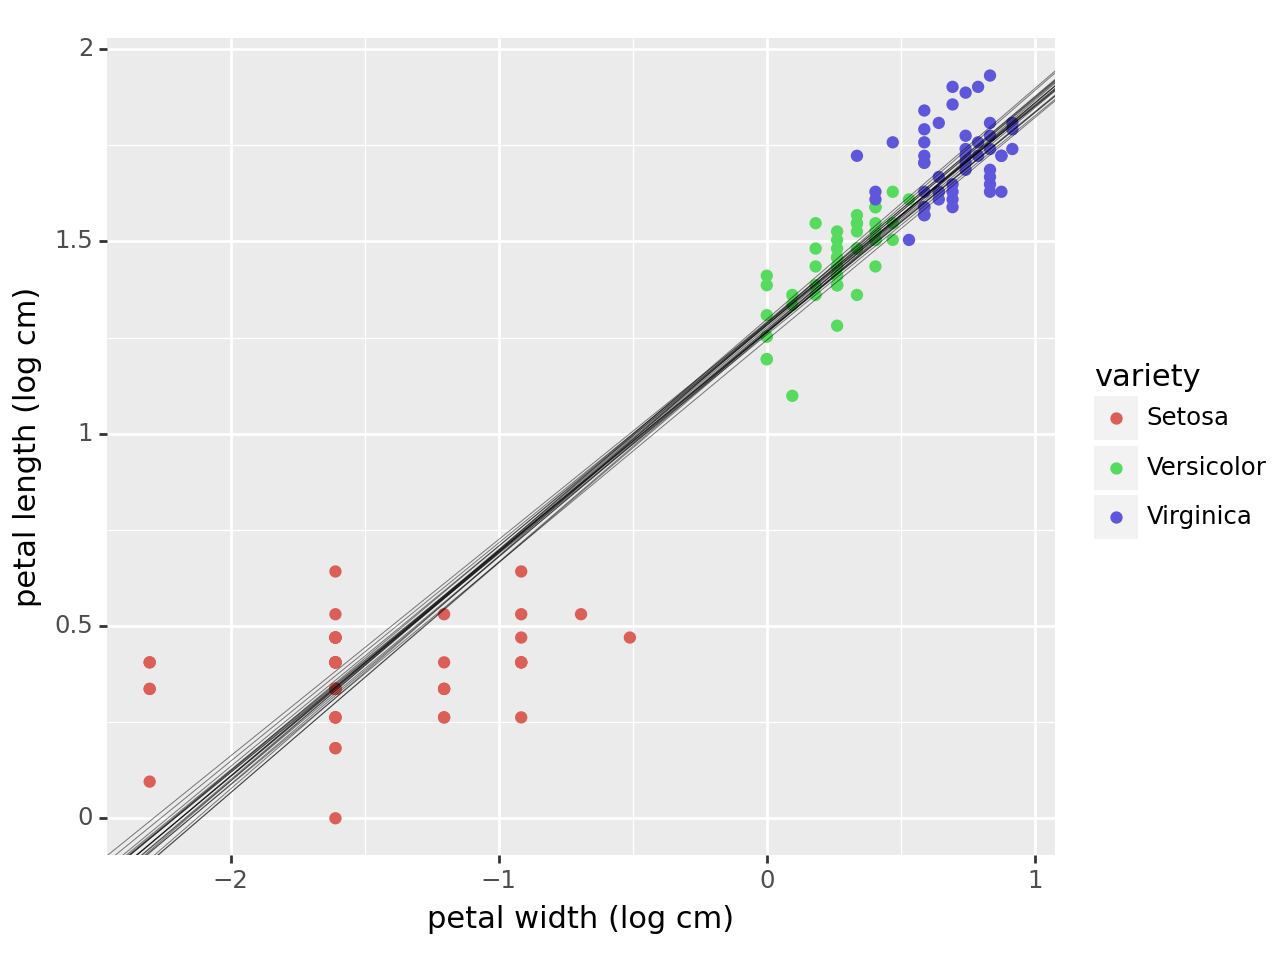

In [81]:
df = iris_data_frame()
df['log_petal_length'] = np.log(df['petal.length'])
df['log_petal_width'] = np.log(df['petal.width'])
alpha_draws = log_sample.stan_variable('alpha')
beta_draws = log_sample.stan_variable('beta')
plot =  pn.ggplot(df, pn.aes(x='log_petal_width',
                             y='log_petal_length',
                 color='variety'))
plot = plot +  pn.geom_point()
plot = plot +  pn.labs(x = "petal width (log cm)",
                       y = "petal length (log cm)")
for a, b in zip(alpha_draws[0:20], beta_draws[0:20]):
    plot = plot + pn.geom_abline(intercept = a, slope = b,
                                 alpha = 0.5, size = 0.2)
mydraw(plot)

In [82]:
# Multi-Indexing for several species

f = open("iris-petals-varying.stan", "w")
f.write("""

data {
  int<lower=0> N;
  vector<lower=0>[N] petal_width;
  vector<lower=0>[N] petal_length;
  int<lower=0> K;
  array[N] int<lower=1, upper=K> species;
}
transformed data {
  vector[N] log_petal_width = log(petal_width);
}
parameters {
  vector[K] alpha;
  vector[K] beta;
  real<lower=0> sigma;
}
model {
  petal_length ~ lognormal(alpha[species] + beta[species] .* log_petal_width,
                           sigma);
  alpha ~ normal(0, 3);
  beta ~ normal(0, 3);
  sigma ~ lognormal(0, 0.6);
}

""")
f.close()

In [83]:
M = 100 if DRAFT else 1000
vary_model = csp.CmdStanModel(
                  stan_file = 'iris-petals-varying.stan')
vary_sample = vary_model.sample(data = iris_data(), seed = 123,
                                iter_warmup = M, iter_sampling = M,     
                                show_progress = False,
                show_console = False)
vary_sample.summary(sig_figs = 2)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,130.000,0.1900,2.100,130.000,130.000,130.00,120.0,1100.0,1.00
alpha[1],0.510,0.0027,0.058,0.400,0.510,0.61,474.0,4392.0,1.00
alpha[2],1.300,0.0020,0.030,1.200,1.300,1.30,225.0,2087.0,1.00
alpha[3],1.500,0.0065,0.072,1.400,1.500,1.70,123.0,1143.0,1.00
beta[1],0.091,0.0017,0.039,0.024,0.092,0.16,504.0,4669.0,0.99
beta[2],0.610,0.0069,0.096,0.450,0.610,0.76,193.0,1785.0,1.00
beta[3],0.230,0.0091,0.100,0.063,0.230,0.38,126.0,1170.0,1.00
sigma,0.100,0.0000,0.000,0.100,0.100,0.10,375.6,3477.8,1.00


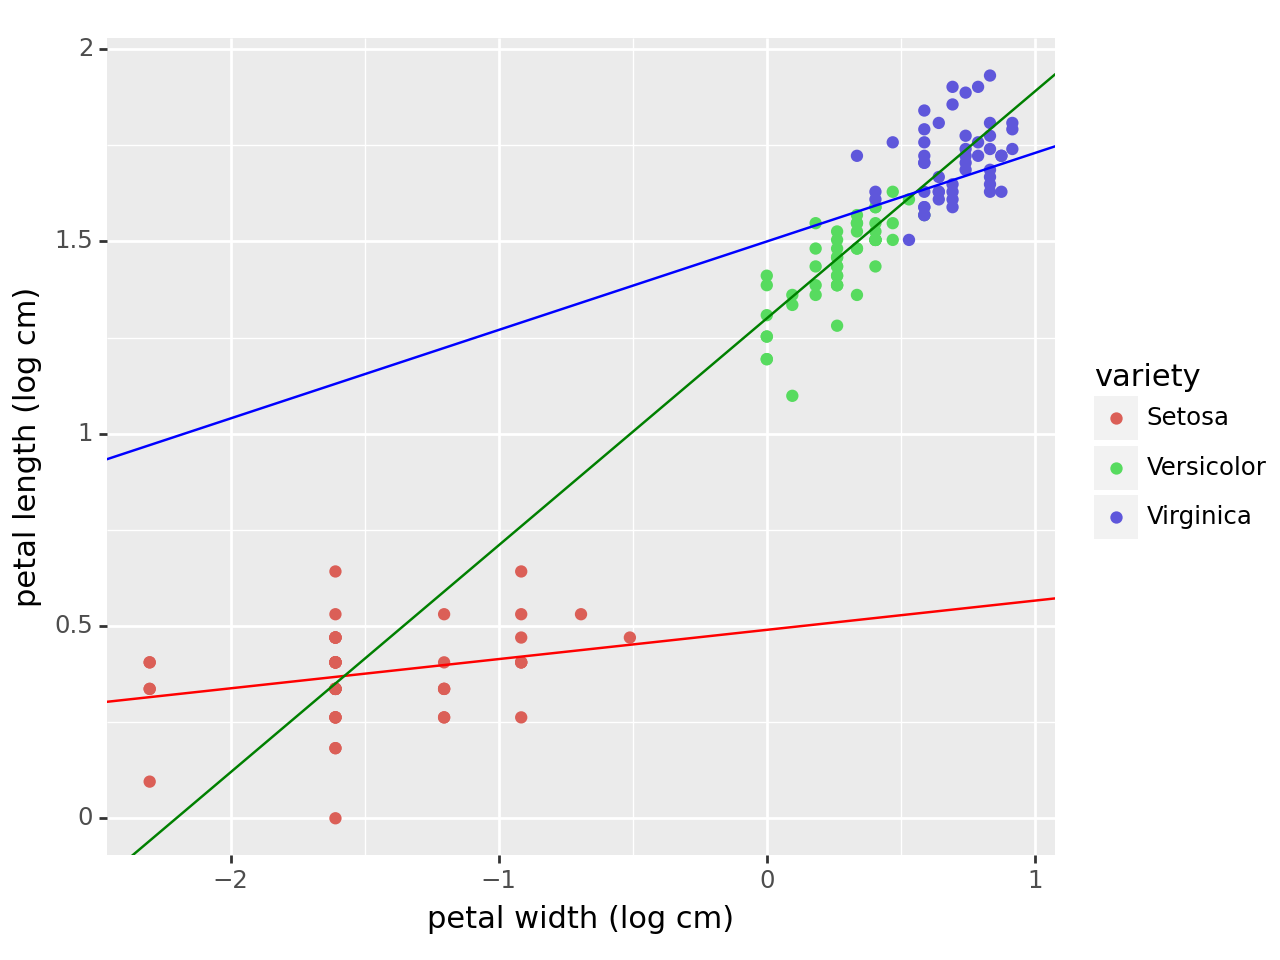

In [84]:
df = iris_data_frame()
df['log_petal_length'] = np.log(df['petal.length'])
df['log_petal_width'] = np.log(df['petal.width'])
plot =  pn.ggplot(df, pn.aes(x='log_petal_width',
                             y='log_petal_length',
                 color='variety'))
plot = plot +  pn.geom_point()
plot = plot +  pn.labs(x = "petal width (log cm)",
                       y = "petal length (log cm)")
plot = plot + pn.geom_abline(intercept = .49, slope = 0.076, color='red')
plot = plot + pn.geom_abline(intercept = 1.30, slope = 0.59, color='green')
plot = plot + pn.geom_abline(intercept = 1.50, slope = 0.23, color='blue')
mydraw(
  plot
)